In [1]:
#!pip install h5py
#!pip install torch torchvision torchaudio
#!pip install scikit-image

In [2]:
import h5py
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import random
import pandas as pd

In [3]:
parent_dir = '/Users/victor/code/afallo/brain_tumor_detection_project/raw_data/Brain Tumor Dataset'

In [4]:
def load_brain_tumor_dataset_h5py(parent_folder):
    """
    Parcourt tous les sous-dossiers, charge tous les fichiers .mat (v7.3 supporté)
    en utilisant h5py, et les stocke dans une liste.
    """

    dataset = []
    count_loaded = 0
    total_files = 0

    # Compter tous les fichiers .mat pour le suivi
    for root, dirs, files in os.walk(parent_folder):
        total_files += len([f for f in files if f.endswith('.mat')])

    print(f"📦 Démarrage du chargement des {total_files} fichiers répartis dans les sous-dossiers (via h5py)...")

    # Parcourir les sous-dossiers et charger
    for root, dirs, files in os.walk(parent_folder):
        mat_files = [f for f in files if f.endswith('.mat')]

        # Ignorer le fichier cvind.mat
        mat_files = [f for f in mat_files if f != 'cvind.mat']

        if mat_files:
            print(f"\n   -> Chargement des fichiers dans : {os.path.basename(root)}...")

            for i, file_name in enumerate(mat_files):
                file_path = os.path.join(root, file_name)

                try:
                    # --- NOUVEAU CHARGEMENT AVEC H5PY ---
                    with h5py.File(file_path, 'r') as f:
                        # La structure de données est maintenant accessible comme un dictionnaire HDF5
                        # L'élément 'cjdata' est la clé principale
                        cjdata = f['cjdata']

                        # Les données stockées sont transposées et souvent encodées.
                        # On utilise .value, .transpose() et np.array pour obtenir la forme correcte.

                        # 1. Image Data (Souvent transposée dans h5py)
                        # np.array() est utilisé pour convertir le Dataset HDF5 en Array NumPy
                        # .transpose() est nécessaire pour retrouver la forme 512x512
                        image_data = np.array(cjdata['image']).transpose()

                        # 2. Masque de Tumeur
                        tumor_mask = np.array(cjdata['tumorMask']).transpose()

                        # 3. Label et PID (Ils sont stockés différemment, nécessitent d'être "déréférencés"
                        # et souvent lus en tant que flotteurs, puis convertis en int/str)
                        label = np.array(cjdata['label'])[0, 0]
                        pid_ref = cjdata['PID'][0, 0]
                        # PID est une référence complexe, nous allons l'ignorer pour l'instant
                        # et utiliser le nom du fichier comme identifiant unique si nécessaire.
                        # Si le PID est un entier simple, on le lit directement, sinon on utilise la méthode d'encodage.
                        # Pour ce dataset, le label est le plus important.

                        # Si le label est lu comme un float, on le convertit en int
                        label = int(label)

                        # Utiliser le nom du fichier comme un identifiant simple si le PID est trop complexe à extraire.
                        pid = file_name.split('.')[0]

                    # Stocker les données
                    sample = {
                        'filename': file_name,
                        'label': label,
                        'PID': pid,
                        'image': image_data,
                        'tumorMask': tumor_mask
                    }

                    dataset.append(sample)
                    count_loaded += 1

                except Exception as e:
                    print(f"⚠️ Erreur H5PY lors du traitement du fichier {file_name} : {e}")
                    # Le code continue au fichier suivant en cas d'erreur

    print(f"\n🎉 Chargement terminé. Total de {count_loaded} images chargées.")
    return dataset

In [5]:
brain_data = load_brain_tumor_dataset_h5py(parent_dir)

📦 Démarrage du chargement des 3065 fichiers répartis dans les sous-dossiers (via h5py)...

   -> Chargement des fichiers dans : brainTumorDataPublic_767-1532...

   -> Chargement des fichiers dans : brainTumorDataPublic_1-766...

   -> Chargement des fichiers dans : brainTumorDataPublic_2299-3064...

   -> Chargement des fichiers dans : brainTumorDataPublic_1533-2298...

🎉 Chargement terminé. Total de 3064 images chargées.



--- Analyse de la Distribution des Classes ---

🔢 Répartition par Type de Tumeur :
  - Méningiome (Label 1): 708 tranches (23.11%)
  - Gliome (Label 2): 1426 tranches (46.54%)
  - Hypophysaire (Label 3): 930 tranches (30.35%)

--- Visualisation d'un Échantillon Aléatoire ---


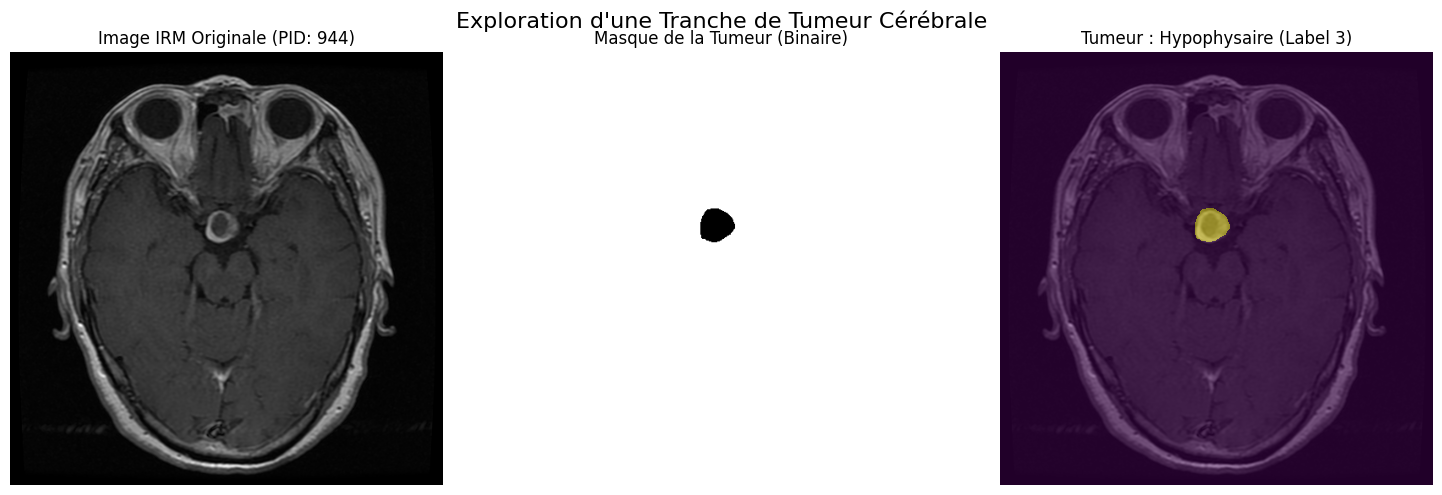

In [6]:
if brain_data:
    print("\n--- Analyse de la Distribution des Classes ---")

    # Extraire toutes les étiquettes (labels)
    labels = [sample['label'] for sample in brain_data]
    label_counts = Counter(labels)
    tumor_names = {1: 'Méningiome', 2: 'Gliome', 3: 'Hypophysaire'}

    print("\n🔢 Répartition par Type de Tumeur :")
    for label, count in sorted(label_counts.items()):
        name = tumor_names.get(label, 'Inconnu')
        print(f"  - {name} (Label {label}): {count} tranches ({count/len(brain_data)*100:.2f}%)")

    # [Le code de visualisation de la distribution (plt.bar) peut être réinséré ici]

    # --- 3. Visualisation d'un Échantillon Aléatoire ---
    if brain_data:
        print("\n--- Visualisation d'un Échantillon Aléatoire ---")
        random_sample = random.choice(brain_data)

        label = random_sample['label']
        name = tumor_names.get(label, 'Inconnu')
        image_data = random_sample['image']
        tumor_mask = random_sample['tumorMask']

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Affichage (le code de visualisation est le même qu'avant)
        axes[0].imshow(image_data, cmap='gray')
        axes[0].set_title(f"Image IRM Originale (PID: {random_sample['PID']})")
        axes[0].axis('off')

        axes[1].imshow(tumor_mask, cmap='binary')
        axes[1].set_title("Masque de la Tumeur (Binaire)")
        axes[1].axis('off')

        axes[2].imshow(image_data, cmap='gray')
        axes[2].imshow(tumor_mask, cmap='viridis', alpha=0.5, interpolation='none')
        axes[2].set_title(f"Tumeur : {name} (Label {label})")
        axes[2].axis('off')

        plt.suptitle(f"Exploration d'une Tranche de Tumeur Cérébrale", fontsize=16)
        plt.tight_layout()
        plt.show()

In [7]:
def load_brain_tumor_to_dataframe(parent_dir):
    """
    Parcourt tous les sous-dossiers, charge tous les fichiers .mat (v7.3 supporté)
    en utilisant h5py, et retourne un DataFrame Pandas contenant les métadonnées et les arrays.

    Args:
        parent_dir (str): Le chemin d'accès au dossier parent 'Brain Tumor Dataset'.

    Returns:
        pd.DataFrame: Un DataFrame contenant les colonnes 'filename', 'label', 'PID',
                      'image', et 'tumorMask'.
    """

    dataset_records = []
    count_loaded = 0
    total_files = 0

    # Compter tous les fichiers .mat pour le suivi
    for root, dirs, files in os.walk(parent_dir):
        total_files += len([f for f in files if f.endswith('.mat')])

    print(f"📦 Démarrage du chargement des {total_files} fichiers pour la création du DataFrame...")

    # Parcourir les sous-dossiers et charger
    for root, dirs, files in os.walk(parent_dir):
        mat_files = [f for f in files if f.endswith('.mat')]

        # Ignorer le fichier cvind.mat
        mat_files = [f for f in mat_files if f != 'cvind.mat']

        if mat_files:
            print(f"\n   -> Chargement des fichiers dans : {os.path.basename(root)}...")

            for i, file_name in enumerate(mat_files):
                file_path = os.path.join(root, file_name)

                try:
                    # NOUVEAU CHARGEMENT AVEC H5PY
                    with h5py.File(file_path, 'r') as f:
                        cjdata = f['cjdata']

                        # Extraction des données et transposition (.transpose() est crucial)
                        image_data = np.array(cjdata['image']).transpose()
                        tumor_mask = np.array(cjdata['tumorMask']).transpose()

                        # Extraction du Label
                        label = int(np.array(cjdata['label'])[0, 0])

                        # Utiliser le nom du fichier comme ID de la tranche
                        pid = file_name.split('.')[0]

                    # Stocker les données dans un dictionnaire (une ligne du futur DataFrame)
                    sample = {
                        'filename': file_name,
                        'label': label,
                        'PID': pid,
                        'image': image_data, # Stocker l'array NumPy complet
                        'tumorMask': tumor_mask # Stocker l'array NumPy complet
                    }

                    dataset_records.append(sample)
                    count_loaded += 1

                except Exception as e:
                    print(f"⚠️ Erreur H5PY lors du traitement du fichier {file_name} : {e}")

    print(f"\n🎉 Chargement terminé. Total de {count_loaded} images chargées.")

    # --- Créer le DataFrame Pandas ---
    df = pd.DataFrame(dataset_records)
    return df

In [8]:
# 1. Chargement et création du DataFrame
brain_df = load_brain_tumor_to_dataframe(parent_dir)

# --- Affichage d'un aperçu du DataFrame ---
if not brain_df.empty:
    print("\n--- Aperçu du DataFrame Créé ---")
    print(f"Taille du DataFrame : {brain_df.shape}")

    # Afficher les 5 premières lignes
    print(brain_df.head())

    print("\nTypes de données des colonnes :")
    print(brain_df.dtypes)

    # Vérification du contenu (optionnel)
    random_row = brain_df.sample(1).iloc[0]
    print(f"\nExemple de données image pour {random_row['filename']} :")
    print(f"  Shape de l'image: {random_row['image'].shape}")
    print(f"  Type de données de l'image: {random_row['image'].dtype}")

📦 Démarrage du chargement des 3065 fichiers pour la création du DataFrame...

   -> Chargement des fichiers dans : brainTumorDataPublic_767-1532...

   -> Chargement des fichiers dans : brainTumorDataPublic_1-766...

   -> Chargement des fichiers dans : brainTumorDataPublic_2299-3064...

   -> Chargement des fichiers dans : brainTumorDataPublic_1533-2298...

🎉 Chargement terminé. Total de 3064 images chargées.

--- Aperçu du DataFrame Créé ---
Taille du DataFrame : (3064, 5)
   filename  label   PID                                              image  \
0  1097.mat      3  1097  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  1083.mat      3  1083  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  1068.mat      3  1068  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  1054.mat      3  1054  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  1040.mat      3  1040  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           tu

In [9]:
brain_df

,filename,label,PID,image,tumorMask
0,1097.mat,3,1097,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1083.mat,3,1083,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1068.mat,3,1068,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1054.mat,3,1054,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1040.mat,3,1040,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
3059,1703.mat,3,1703,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3060,1717.mat,3,1717,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3061,1924.mat,2,1924,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3062,1930.mat,2,1930,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
OUTPUT_DIR = 'data/processed'  # Créez un dossier pour les données traitées
OUTPUT_FILENAME = 'brain_tumor_df_processed.pkl'
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

# Créer le dossier s'il n'existe pas
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Exportation au format Pickle
try:
    # ⚠️ Assurez-vous que 'brain_df' est bien le nom de votre DataFrame
    brain_df.to_pickle(OUTPUT_PATH)

    print(f"🎉 DataFrame exporté avec succès sous : {OUTPUT_PATH}")
    print("Ce fichier est prêt à être ajouté à Git.")

except Exception as e:
    print(f"❌ Erreur lors de l'exportation : {e}")

🎉 DataFrame exporté avec succès sous : data/processed/brain_tumor_df_processed.pkl
Ce fichier est prêt à être ajouté à Git.


In [36]:
import pandas as pd
import numpy as np
import os

def convert_tensors_to_images(df, image_col='image', mask_col='tumorMask',
                              normalize_method='preserve'):
    """
    Convertit les tensors numpy en images PIL dans un DataFrame.

    Args:
        df: DataFrame contenant les colonnes avec des tensors numpy
        image_col: nom de la colonne contenant les tensors d'images
        mask_col: nom de la colonne contenant les tensors de masques
        normalize_method:
            - 'preserve': Garde les valeurs originales (recommandé pour ML)
            - 'minmax': Normalise min-max sur chaque image (améliore contraste)
            - 'global': Normalise avec min/max global du dataset
            - 'percentile': Utilise les percentiles 1-99 (robuste aux outliers)

    Returns:
        DataFrame avec les colonnes converties en images PIL
    """
    try:
        from PIL import Image
    except ImportError:
        raise ImportError("PIL/Pillow n'est pas installé. Installez-le avec: pip install Pillow")

    def analyze_tensor_range(tensor):
        """Analyse les valeurs du tensor"""
        return {
            'min': float(tensor.min()),
            'max': float(tensor.max()),
            'mean': float(tensor.mean()),
            'std': float(tensor.std()),
            'dtype': str(tensor.dtype)
        }

    def normalize_tensor(tensor, method='preserve', global_min=None, global_max=None):
        """Normalise un tensor selon la méthode choisie"""
        tensor = tensor.astype(np.float32)

        if method == 'preserve':
            # Ne rien faire si déjà dans [0, 255]
            if tensor.min() >= 0 and tensor.max() <= 255:
                return tensor.astype(np.uint8)
            # Sinon, clip aux valeurs valides
            return np.clip(tensor, 0, 255).astype(np.uint8)

        elif method == 'minmax':
            # Normalisation min-max par image
            t_min, t_max = tensor.min(), tensor.max()
            if t_max - t_min > 0:
                tensor = (tensor - t_min) / (t_max - t_min) * 255
            return tensor.astype(np.uint8)

        elif method == 'global':
            # Normalisation avec min/max global
            if global_min is not None and global_max is not None:
                if global_max - global_min > 0:
                    tensor = (tensor - global_min) / (global_max - global_min) * 255
                    return np.clip(tensor, 0, 255).astype(np.uint8)
            return tensor.astype(np.uint8)

        elif method == 'percentile':
            # Normalisation robuste avec percentiles
            p1, p99 = np.percentile(tensor, [1, 99])
            if p99 - p1 > 0:
                tensor = np.clip(tensor, p1, p99)
                tensor = (tensor - p1) / (p99 - p1) * 255
            return tensor.astype(np.uint8)

        else:
            raise ValueError(f"Méthode inconnue: {method}")

    def tensor_to_pil(tensor, method='preserve', global_min=None, global_max=None):
        """Convertit un tensor numpy en image PIL"""
        if tensor is None:
            return None

        if not isinstance(tensor, np.ndarray):
            tensor = np.array(tensor)

        # Normaliser le tensor
        tensor = normalize_tensor(tensor, method, global_min, global_max)

        # Créer l'image PIL selon la forme du tensor
        if len(tensor.shape) == 2:  # Grayscale (H, W)
            return Image.fromarray(tensor, mode='L')
        elif len(tensor.shape) == 3:
            if tensor.shape[2] == 1:  # (H, W, 1) -> Grayscale
                return Image.fromarray(tensor[:, :, 0], mode='L')
            elif tensor.shape[2] == 3:  # (H, W, 3) -> RGB
                return Image.fromarray(tensor, mode='RGB')
            elif tensor.shape[2] == 4:  # (H, W, 4) -> RGBA
                return Image.fromarray(tensor, mode='RGBA')

        raise ValueError(f"Forme de tensor non supportée: {tensor.shape}")

    # Analyser les valeurs du dataset
    print("🔍 Analyse des valeurs du dataset...")
    sample_tensor = df[image_col].iloc[0]
    if not isinstance(sample_tensor, np.ndarray):
        sample_tensor = np.array(sample_tensor)

    stats = analyze_tensor_range(sample_tensor)
    print(f"   Type: {stats['dtype']}")
    print(f"   Plage: [{stats['min']:.2f}, {stats['max']:.2f}]")
    print(f"   Moyenne: {stats['mean']:.2f}, Écart-type: {stats['std']:.2f}")

    # Calculer min/max global si nécessaire
    global_min, global_max = None, None
    if normalize_method == 'global':
        print("   Calcul des statistiques globales...")
        all_values = []
        for tensor in df[image_col].head(min(100, len(df))):  # Sample de 100 images max
            if not isinstance(tensor, np.ndarray):
                tensor = np.array(tensor)
            all_values.extend([tensor.min(), tensor.max()])
        global_min, global_max = min(all_values), max(all_values)
        print(f"   Global: [{global_min:.2f}, {global_max:.2f}]")

    # Avertissement sur la méthode
    if normalize_method != 'preserve':
        print(f"⚠️  Méthode '{normalize_method}' : Les valeurs seront normalisées")
        print(f"   Cela peut améliorer le contraste mais modifie les valeurs originales")

    # Créer une copie du DataFrame
    df_converted = df.copy()

    # Convertir la colonne des images
    if image_col in df_converted.columns:
        print(f"\n🖼️  Conversion de la colonne '{image_col}'...")
        df_converted[image_col] = df_converted[image_col].apply(
            lambda x: tensor_to_pil(x, normalize_method, global_min, global_max)
        )

    # Convertir la colonne des masques (toujours en preserve pour les masques)
    if mask_col in df_converted.columns:
        print(f"🎭 Conversion de la colonne '{mask_col}' (preserve mode)...")
        df_converted[mask_col] = df_converted[mask_col].apply(
            lambda x: tensor_to_pil(x, 'preserve')
        )

    print("✅ Conversion terminée!")
    return df_converted

In [51]:
df_converted = convert_tensors_to_images(brain_df, 'image', 'tumorMask', normalize_method='preserve')

🔍 Analyse des valeurs du dataset...
   Type: int16
   Plage: [0.00, 1970.00]
   Moyenne: 468.52, Écart-type: 350.49

🖼️  Conversion de la colonne 'image'...
🎭 Conversion de la colonne 'tumorMask' (preserve mode)...
✅ Conversion terminée!


In [52]:
df_converted.head()

,filename,label,PID,image,tumorMask
0,1097.mat,3,1097,<PIL.Image.Image image mode=L size=512x512 at ...,<PIL.Image.Image image mode=L size=512x512 at ...
1,1083.mat,3,1083,<PIL.Image.Image image mode=L size=512x512 at ...,<PIL.Image.Image image mode=L size=512x512 at ...
2,1068.mat,3,1068,<PIL.Image.Image image mode=L size=512x512 at ...,<PIL.Image.Image image mode=L size=512x512 at ...
3,1054.mat,3,1054,<PIL.Image.Image image mode=L size=512x512 at ...,<PIL.Image.Image image mode=L size=512x512 at ...
4,1040.mat,3,1040,<PIL.Image.Image image mode=L size=512x512 at ...,<PIL.Image.Image image mode=L size=512x512 at ...


In [54]:
df_converted['image'][45].show()

In [55]:
OUTPUT_DIR = 'exported_data_set'
IMAGES_DIR = os.path.join(OUTPUT_DIR, 'images')
os.makedirs(IMAGES_DIR, exist_ok=True)

# Créer une copie pour travailler
df_export = df_converted.copy()

# Créer de nouvelles colonnes pour les chemins
df_export['image_path'] = ''
df_export['mask_path'] = ''

print(f"Dossier de sortie créé : {IMAGES_DIR}")
print("Début de la sauvegarde des images...")

for index, row in df_export.iterrows():
    # Créer un nom de fichier unique basé sur le PID
    base_name = f"{row['PID']}_{index}"

    # 🖼️ Sauvegarde de l'image principale en JPG
    img_filename = f"{base_name}_img.jpg"
    img_filepath = os.path.join(IMAGES_DIR, img_filename)
    row['image'].save(img_filepath, format='JPEG', quality=90)
    df_export.loc[index, 'image_path'] = img_filepath

    # 🎭 Sauvegarde du masque en PNG
    mask_filename = f"{base_name}_mask.png"
    mask_filepath = os.path.join(IMAGES_DIR, mask_filename)
    row['tumorMask'].save(mask_filepath, format='PNG')
    df_export.loc[index, 'mask_path'] = mask_filepath

print("Sauvegarde des images terminée.")

Dossier de sortie créé : exported_data_set/images
Début de la sauvegarde des images...
Sauvegarde des images terminée.


In [57]:
import numpy as np
from PIL import Image

# Charger l'image du masque (utilisez le chemin enregistré dans votre DataFrame)
mask_image = Image.open('/Users/victor/code/afallo/brain_tumor_detection_project/notebooks/EDA_Victor/exported_data_set/images/1_1175_mask.png')
mask_np = np.array(mask_image)

# 1. Vérifier les dimensions
print(f"Dimensions du masque : {mask_np.shape}") # Devrait être (512, 512)

# 2. Vérifier les valeurs uniques (pour voir si 1 ou 255 est présent)
print(f"Valeurs uniques : {np.unique(mask_np)}") # Devrait contenir 0 et une autre valeur (ex: 1 ou 255)

# 3. Compter les pixels non-zéro (la zone de la tumeur)
non_zero_pixels = np.sum(mask_np > 0)
print(f"Nombre de pixels de tumeur (non-zéro) : {non_zero_pixels}")

Dimensions du masque : (512, 512)
Valeurs uniques : [0 1]
Nombre de pixels de tumeur (non-zéro) : 4569
